In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [111]:
df = pd.read_csv("data_centers_original.csv")
df.head()

,country,total_data_centers,hyperscale_data_centers,colocation_data_centers,floor_space_sqft_total,power_capacity_MW_total,average_renewable_energy_usage_percent,internet_penetration_percent,growth_rate_of_data_centers_percent_per_year,cooling_technologies_common
0,United States,5426,300,2000,3.552000e+09,12000.0,27.00,92.0,12.0,"Air, Liquid, Immersion"
1,Germany,529,50,200,3.500000e+08,2000.0,40.00,92.0,8.0,"Air, Indirect Evap."
2,United Kingdom,523,30,150,2.000000e+08,1000.0,0.45,96.0,7.0,"Air, Free Cooling"
3,China,449,100,1000,5.000000e+08,8000.0,0.25,76.0,15.0,"Air, Liquid"
4,France,322,20,110,1.200000e+08,700.0,40.00,91.0,6.0,"Air, Liquid"


In [112]:
df.dtypes

country                                          object
total_data_centers                                int64
hyperscale_data_centers                           int64
colocation_data_centers                           int64
floor_space_sqft_total                          float64
power_capacity_MW_total                         float64
average_renewable_energy_usage_percent          float64
internet_penetration_percent                    float64
growth_rate_of_data_centers_percent_per_year    float64
cooling_technologies_common                      object
dtype: object

In [113]:
cols = df.columns
for column in df:
    columnSeriesObj = df[column]
    print('Column Name : ', column)
    print('length : ', len(columnSeriesObj.unique()))

Column Name :  country
length :  191
Column Name :  total_data_centers
length :  57
Column Name :  hyperscale_data_centers
length :  15
Column Name :  colocation_data_centers
length :  46
Column Name :  floor_space_sqft_total
length :  99
Column Name :  power_capacity_MW_total
length :  53
Column Name :  average_renewable_energy_usage_percent
length :  88
Column Name :  internet_penetration_percent
length :  106
Column Name :  growth_rate_of_data_centers_percent_per_year
length :  78
Column Name :  cooling_technologies_common
length :  97


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 10 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   country                                       191 non-null    object 
 1   total_data_centers                            191 non-null    int64  
 2   hyperscale_data_centers                       191 non-null    int64  
 3   colocation_data_centers                       191 non-null    int64  
 4   floor_space_sqft_total                        184 non-null    float64
 5   power_capacity_MW_total                       165 non-null    float64
 6   average_renewable_energy_usage_percent        148 non-null    float64
 7   internet_penetration_percent                  190 non-null    float64
 8   growth_rate_of_data_centers_percent_per_year  174 non-null    float64
 9   cooling_technologies_common                   145 non-null    obj

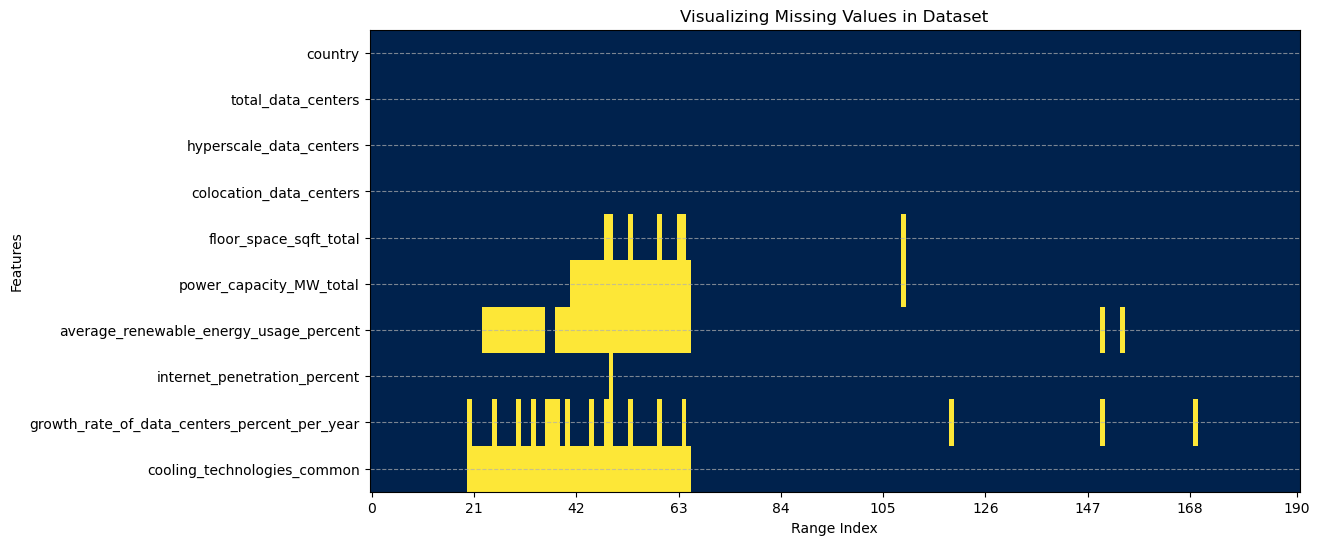

In [115]:
data_centers_columns = df[['country', 'total_data_centers', 'hyperscale_data_centers',
       'colocation_data_centers', 'floor_space_sqft_total',
       'power_capacity_MW_total', 'average_renewable_energy_usage_percent',
       'internet_penetration_percent',
       'growth_rate_of_data_centers_percent_per_year',
       'cooling_technologies_common']]

nan_mask = data_centers_columns.isna()
nan_array = nan_mask.astype(int).to_numpy()

plt.figure(figsize=(12, 6))
im = plt.imshow(nan_array.T, interpolation='nearest', aspect='auto', cmap='cividis')
plt.xlabel('Range Index')
plt.ylabel('Features')
plt.title('Visualizing Missing Values in Dataset')

plt.yticks(range(len(data_centers_columns.columns)), data_centers_columns.columns)

data_centers_columns_values = nan_array.shape[0]
plt.xticks(np.linspace(0, data_centers_columns_values-1, min(10, data_centers_columns_values)).astype(int)) 
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

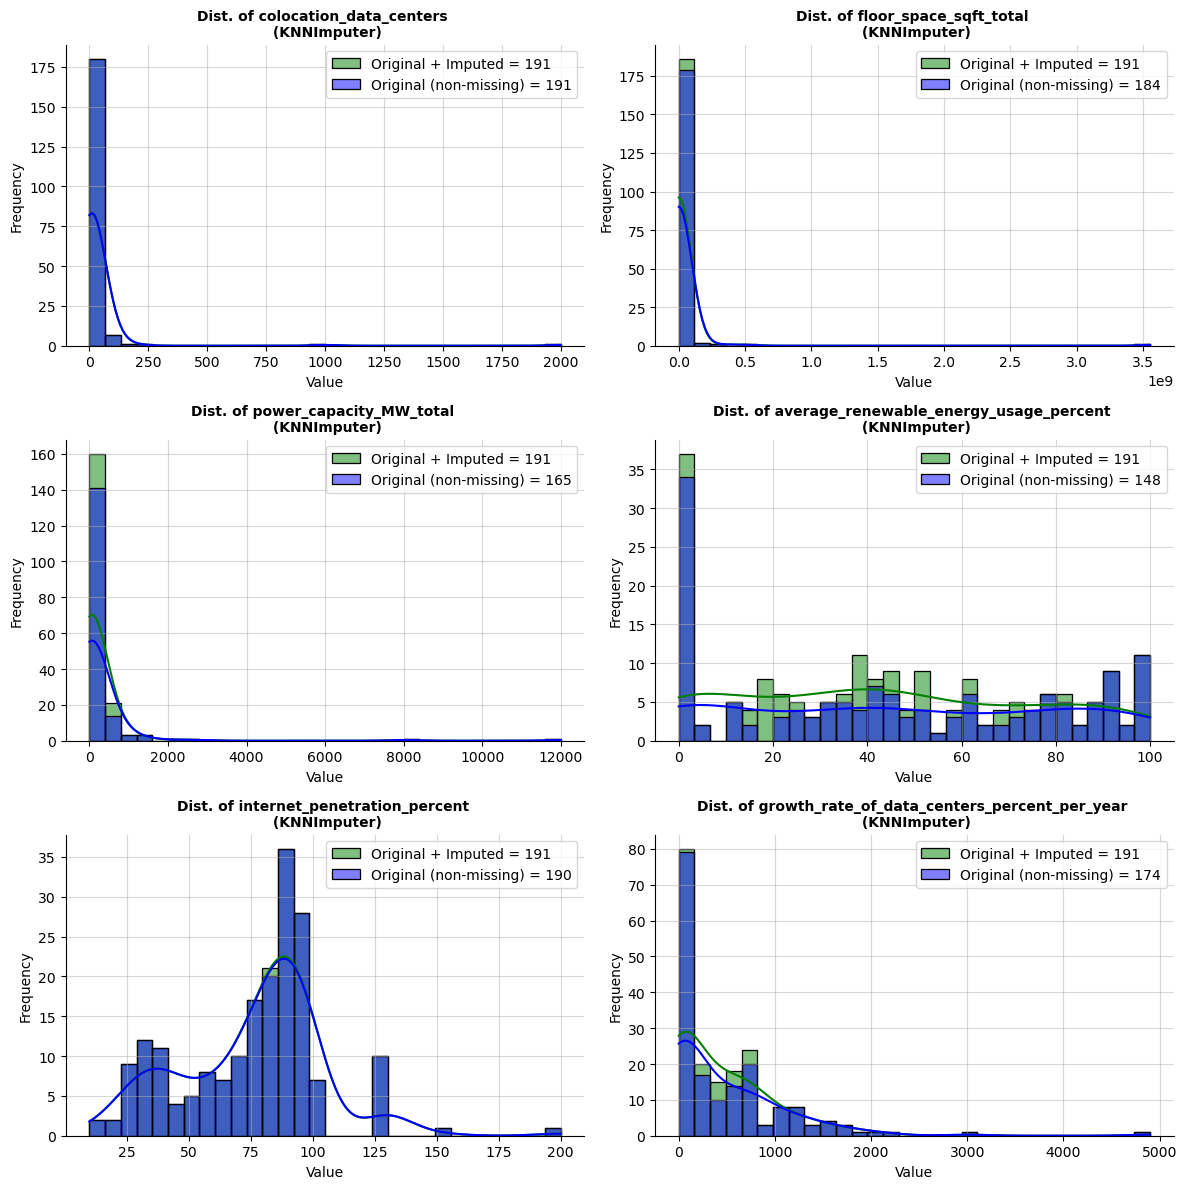

In [116]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_columns]

df_with_missing = df_numeric[df_numeric.isnull().any(axis=1)]
df_without_missing = df_numeric.dropna()

# prepare the data for KNN imputation
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_without_missing), columns=df_without_missing.columns)

# initialize and fit KNN imputer
imputer = KNNImputer(n_neighbors=5)
imputer.fit(df_scaled)

# function to impute and inverse transform the data
def impute_and_inverse_transform(data):
    scaled_data = pd.DataFrame(scaler.transform(data), columns=data.columns, index=data.index)
    imputed_scaled = imputer.transform(scaled_data)
    return pd.DataFrame(scaler.inverse_transform(imputed_scaled), columns=data.columns, index=data.index)

df_imputed = impute_and_inverse_transform(df_numeric)
df_combined_knn = df_numeric.fillna(df_imputed)

columns_to_plot = df_combined_knn.columns[2:]
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

for i, ax in enumerate(axs.flatten()):
    col_name = columns_to_plot[i]
    sns.histplot(df_combined_knn[col_name], ax=ax, kde=True, color='green', bins=30, alpha=0.5, label=f'Original + Imputed = {len(df_combined_knn[col_name])}')
    sns.histplot(df_numeric[col_name].dropna(), ax=ax, kde = True, color='blue', bins = 30, alpha=0.5, label=f'Original (non-missing) = {len(df_numeric[col_name].dropna())}')
    ax.set_title(f'Dist. of {col_name} \n (KNNImputer)', fontsize=10, fontweight = 'bold')
    ax.legend()
    ax.grid(alpha = 0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Value', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)

plt.tight_layout()
plt.show()

In [101]:
from sklearn.impute import SimpleImputer
import numpy as np
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
numeric_columns = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_columns]
imputer.fit(df_numeric)
imputed_array = imputer.transform(df_numeric)

imputed_data = pd.DataFrame(imputed_array, columns=df_numeric.columns, index=df_numeric.index)
imputed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 8 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   total_data_centers                            191 non-null    float64
 1   hyperscale_data_centers                       191 non-null    float64
 2   colocation_data_centers                       191 non-null    float64
 3   floor_space_sqft_total                        191 non-null    float64
 4   power_capacity_MW_total                       191 non-null    float64
 5   average_renewable_energy_usage_percent        191 non-null    float64
 6   internet_penetration_percent                  191 non-null    float64
 7   growth_rate_of_data_centers_percent_per_year  191 non-null    float64
dtypes: float64(8)
memory usage: 12.1 KB


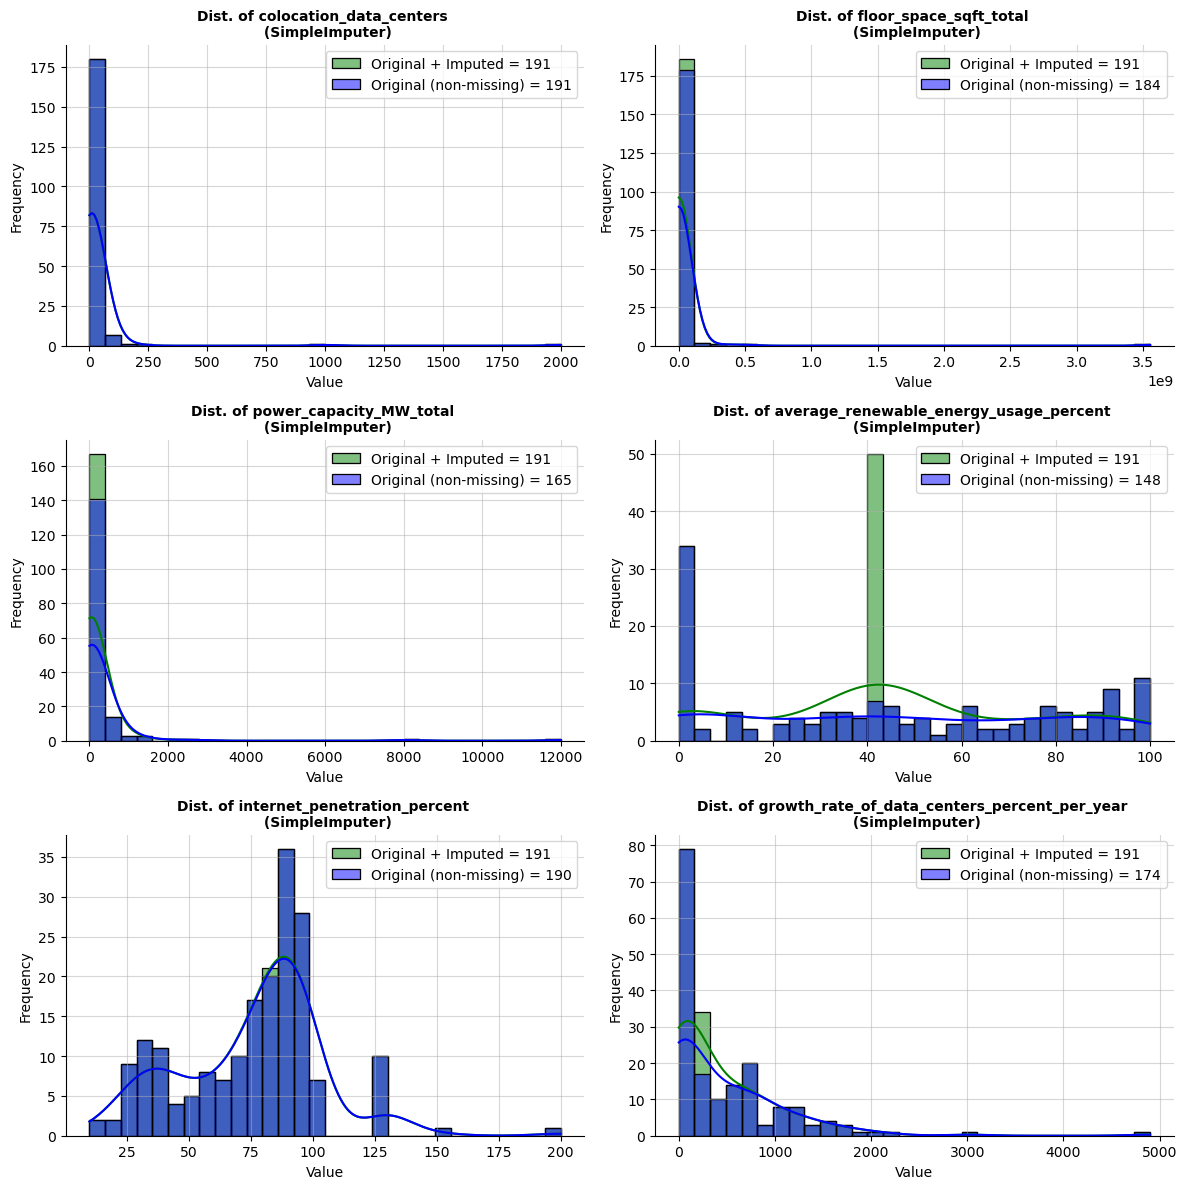

In [108]:
columns_to_plot = df_combined.columns[2:]
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
df_combined = df_numeric.fillna(imputed_data)
for i, ax in enumerate(axs.flatten()):
    col_name = columns_to_plot[i]
    sns.histplot(df_combined[col_name], ax=ax, kde=True, color='green', bins=30, alpha=0.5, label=f'Original + Imputed = {len(df_combined[col_name])}')
    sns.histplot(df_numeric[col_name].dropna(), ax=ax, kde = True, color='blue', bins = 30, alpha=0.5, label=f'Original (non-missing) = {len(df_numeric[col_name].dropna())}')
    ax.set_title(f'Dist. of {col_name} \n (SimpleImputer)', fontsize=10, fontweight = 'bold')
    ax.legend()
    ax.grid(alpha = 0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Value', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
plt.tight_layout()
plt.show()

In [121]:
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
df_final = pd.concat([df[non_numeric_cols], df_combined_knn], axis=1)
df_final.to_csv("imputed_df.csv", index=False)

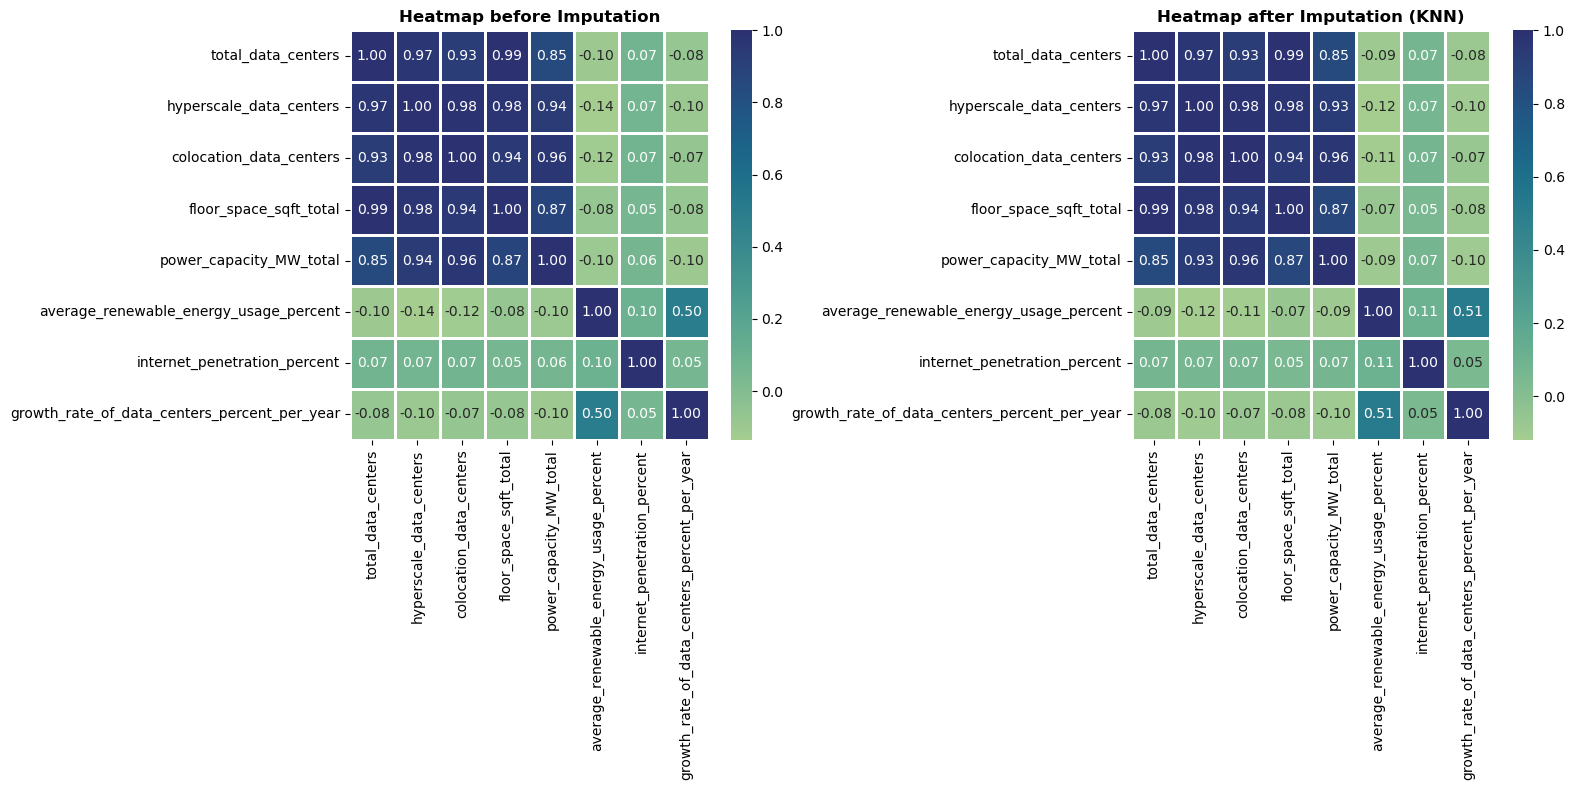

In [159]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

data_og = pd.read_csv("data_centers_original.csv")
corr_pre_imp = data_og.corr(numeric_only=True)
sns.heatmap(corr_pre_imp, annot=True, linewidth=0.8, cmap="crest", fmt=".2f", ax=ax1)
ax1.set_title("Heatmap before Imputation", fontweight='bold', fontsize=12)

data_post_imp = pd.read_csv("imputed_df.csv")
corr_post_imp = data_post_imp.corr(numeric_only=True)
sns.heatmap(corr_post_imp, annot=True, linewidth=0.8, cmap="crest", fmt=".2f", ax=ax2)
ax2.set_title("Heatmap after Imputation (KNN)", fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()